In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/AbbeyGrange075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2022-12-31 18:18:24 - INFO - 3505047770.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/AbbeyGrange075/03/log.log', param_file='saved_models/kgc/AbbeyGrange075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/AbbeyGrange075/03/checkpoint/', model_path='saved_models/kgc/AbbeyGrange075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='AbbeyGrange', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_t

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2022-12-31 18:18:24 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2022-12-31 18:18:24 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 18:18:24 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 18:18:24 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 18:18:24 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 18:18:24 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2022-12-31 18:18:24 - INFO - data_helper.py - 441 - ==========
2022-12-31 18:18:24 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2022-12-31 18:18:24 - INFO - data_helper.py - 208 - entity_length: 7844
2022-12-31 18:18:24 - INFO - data_helper.py - 209 - relation_length: 63
2022-12-31 18:18:24 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2022-12-31 18:18:24 - INFO - data_helper.py - 443 - ==========
2022-12-31 18:18:24 - INFO - data_helper.py - 445 - entity_spec

13704 16821


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

### 僧坊荘園
Who killed Lord Blackenstall? (criminal & explanation)
被害者: Sir_Eustace_Brackenstall
犯人: 
犯行動機: 

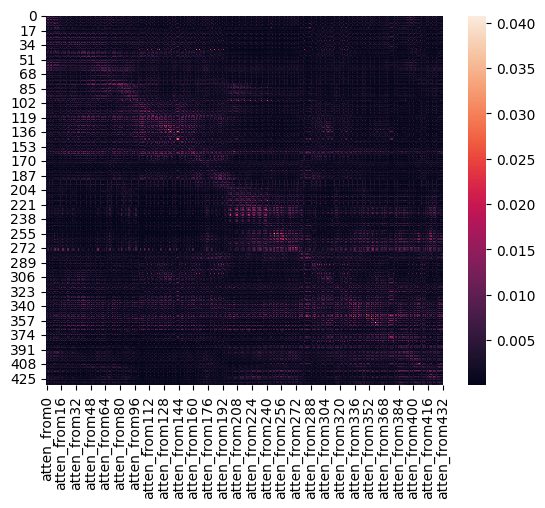

,predicate,whom,subject,why,what,where
0,word.predicate:exist,AbbeyGrange:Criminal,AbbeyGrange:Jack_Croker,AbbeyGrange:Lady_Brackenstall,ACaseOfIdentity:Sutherland,AllTitle:Holmes
1,word.predicate:kill,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Sir_Eustace_Brackenstall,AllTitle:Holmes,AbbeyGrange:Theresa
2,word.predicate:sit,AllTitle:Holmes,AbbeyGrange:Criminal,CrookedMan:Morrison,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:dining_room
3,word.predicate:say,AbbeyGrange:Sir_Eustace_Brackenstall,AbbeyGrange:Sir_Eustace_Brackenstall,ACaseOfIdentity:Hosmer,AbbeyGrange:Lady_Brackenstall,AbbeyGrange:Lady_Brackenstall
4,word.predicate:find,ACaseOfIdentity:Sutherland,CrookedMan:Rasheen,CrookedMan:Teddy,CrookedMan:Murphy,ACaseOfIdentity:Sutherland
5,word.predicate:enter,AbbeyGrange:Jack_Croker,AbbeyGrange:Theresa,AbbeyGrange:Theresa,ACaseOfIdentity:Hosmer,DateTime:1898-08-13T03:02:00
6,word.predicate:have,CrookedMan:Barclay,DateTime:1898-08-13T03:02:00,AbbeyGrange:dust,AbbeyGrange:Jack_Croker,AbbeyGrange:Thought_of_Stanley_Hopkins
7,word.predicate:go,SilverBlaze:Fitzroy_Simpson,AllTitle:Holmes,word.predicate:see,AllTitle:Watson,DevilsFoot:living_room
8,word.predicate:notExist,SilverBlaze:Silas_Brown,CrookedMan:Barclay,AbbeyGrange:Criminal,CrookedMan:Barclay,AbbeyGrange:Stanley_Hopkins
9,ACaseOfIdentity:Sutherland,AbbeyGrange:Theresa,AbbeyGrange:Stanley_Hopkins,DancingMen:Horse_boy,CrookedMan:Henry,SilverBlaze:Silver_Blaze


413

['AbbeyGrange:307', 'kgc:when', 'AbbeyGrange:end_of_case']

,head,relation,tail,atten_from413
349,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.015013
322,AbbeyGrange:291,kgc:what,AbbeyGrange:290,0.012258
384,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.009627
273,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.009495
376,AbbeyGrange:300,kgc:what,AbbeyGrange:298,0.009482
271,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.008807
345,AbbeyGrange:295,kgc:subject,AbbeyGrange:pond_of_garden,0.008651
375,AbbeyGrange:300,kgc:what,AbbeyGrange:297,0.008603
272,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.008497
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.008494


----------


414

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from414
21,bos_e,bos_r,bos_e,0.006657
15,bos_e,bos_r,bos_e,0.006493
219,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.006356
32,bos_e,bos_r,bos_e,0.006183
26,bos_e,bos_r,bos_e,0.006121
10,bos_e,bos_r,bos_e,0.005992
105,bos_e,bos_r,bos_e,0.005951
109,bos_e,bos_r,bos_e,0.005947
212,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.005925
92,bos_e,bos_r,bos_e,0.005878


----------


415

['AbbeyGrange:308', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from415
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.020947
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.013985
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.013040
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.012946
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012295
349,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.011314
405,AbbeyGrange:306,kgc:subject,AbbeyGrange:Stanley_Hopkins,0.011218
338,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010872
347,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010846
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.010654


----------


416

['AbbeyGrange:308', 'kgc:hasProperty', 'word.predicate:manly']

,head,relation,tail,atten_from416
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.013878
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.013533
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.012525
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.012091
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.011719
230,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.011076
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.010981
271,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.009998
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.009543
224,AbbeyGrange:273,kgc:subject,AbbeyGrange:Jack_Croker,0.009507


----------


417

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from417
21,bos_e,bos_r,bos_e,0.006689
15,bos_e,bos_r,bos_e,0.006513
219,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.006448
32,bos_e,bos_r,bos_e,0.006193
26,bos_e,bos_r,bos_e,0.006161
212,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.006052
10,bos_e,bos_r,bos_e,0.005979
105,bos_e,bos_r,bos_e,0.005954
109,bos_e,bos_r,bos_e,0.005940
92,bos_e,bos_r,bos_e,0.005907


----------


418

['AbbeyGrange:309', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from418
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.040759
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.018629
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.017505
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.015802
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.015074
272,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.011697
416,AbbeyGrange:308,kgc:hasProperty,word.predicate:manly,0.011541
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.010953
269,AbbeyGrange:282,kgc:hasProperty,word.predicate:inpatient,0.010768
349,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.010399


----------


419

['AbbeyGrange:309', 'kgc:hasPredicate', 'word.predicate:come']

,head,relation,tail,atten_from419
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.020132
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.017873
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.016954
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.014531
257,AbbeyGrange:279,kgc:what,AbbeyGrange:Comparable_Officer,0.013817
273,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.012001
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011029
416,AbbeyGrange:308,kgc:hasProperty,word.predicate:manly,0.010894
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.010748
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.010191


----------


420

['AbbeyGrange:309', 'kgc:where', 'AbbeyGrange:room_of_Holmes']

,head,relation,tail,atten_from420
258,AbbeyGrange:279,kgc:where,AbbeyGrange:any_ship,0.016988
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.015837
420,AbbeyGrange:309,kgc:where,AbbeyGrange:room_of_Holmes,0.015550
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.015419
257,AbbeyGrange:279,kgc:what,AbbeyGrange:Comparable_Officer,0.013652
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.013621
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.012453
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011884
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.011162
247,AbbeyGrange:277,kgc:subject,AbbeyGrange:Jack_Croker,0.010482


----------


421

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from421
21,bos_e,bos_r,bos_e,0.006643
219,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.006642
15,bos_e,bos_r,bos_e,0.006492
212,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.006483
32,bos_e,bos_r,bos_e,0.006148
26,bos_e,bos_r,bos_e,0.006104
10,bos_e,bos_r,bos_e,0.005959
105,bos_e,bos_r,bos_e,0.005934
109,bos_e,bos_r,bos_e,0.005930
92,bos_e,bos_r,bos_e,0.005921


----------


422

['AbbeyGrange:310', 'kgc:subject', 'AbbeyGrange:Jack_Croker']

,head,relation,tail,atten_from422
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.024780
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.018158
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.014414
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.014035
416,AbbeyGrange:308,kgc:hasProperty,word.predicate:manly,0.012329
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012227
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.011218
362,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.011120
364,AbbeyGrange:299,kgc:subject,AbbeyGrange:Criminal,0.010839
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.010702


----------


423

['AbbeyGrange:310', 'kgc:hasProperty', 'word.predicate:nimble-footed']

,head,relation,tail,atten_from423
230,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.012591
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.012270
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.011279
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.010942
224,AbbeyGrange:273,kgc:subject,AbbeyGrange:Jack_Croker,0.010197
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.009818
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.009040
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.008760
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.008551
247,AbbeyGrange:277,kgc:subject,AbbeyGrange:Jack_Croker,0.008503


----------


424

['AbbeyGrange:310', 'kgc:when', 'AbbeyGrange:309']

,head,relation,tail,atten_from424
230,AbbeyGrange:274,kgc:subject,AbbeyGrange:Jack_Croker,0.011813
268,AbbeyGrange:282,kgc:subject,AbbeyGrange:Jack_Croker,0.011261
236,AbbeyGrange:275,kgc:subject,AbbeyGrange:The_Bays_Rock,0.009248
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.008559
234,AbbeyGrange:274,kgc:time,DateTime:1897-02-01T12:00:00,0.008315
272,AbbeyGrange:283,kgc:hasProperty,word.predicate:Friendly,0.007896
273,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.007808
271,AbbeyGrange:283,kgc:subject,AbbeyGrange:Jack_Croker,0.007769
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.007749
228,AbbeyGrange:273,kgc:time,DateTime:1895-02-01T12:00:00,0.007353


----------


425

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from425
21,bos_e,bos_r,bos_e,0.006613
219,AbbeyGrange:272,kgc:hasPredicate,word.predicate:exist,0.006594
15,bos_e,bos_r,bos_e,0.006466
212,AbbeyGrange:271,kgc:hasPredicate,word.predicate:exist,0.006443
32,bos_e,bos_r,bos_e,0.006142
26,bos_e,bos_r,bos_e,0.006083
105,bos_e,bos_r,bos_e,0.005974
109,bos_e,bos_r,bos_e,0.005965
10,bos_e,bos_r,bos_e,0.005946
92,bos_e,bos_r,bos_e,0.005933


----------


426

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from426
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.011801
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.011142
422,AbbeyGrange:310,kgc:subject,AbbeyGrange:Jack_Croker,0.009680
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008940
384,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.008819
367,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007960
388,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.007954
158,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.007826
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007774
380,AbbeyGrange:301,kgc:subject,AbbeyGrange:Stanley_Hopkins,0.007730


----------


427

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from427
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.011688
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.010898
384,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.010354
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.009816
322,AbbeyGrange:291,kgc:what,AbbeyGrange:290,0.009272
273,AbbeyGrange:283,kgc:hasProperty,word.predicate:faithful,0.009027
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008215
362,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008213
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.007971
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.007938


----------


428

['mask_e', 'kgc:whom', 'AbbeyGrange:Sir_Eustace_Brackenstall']

,head,relation,tail,atten_from428
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.021560
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.017744
367,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.016604
362,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.016199
338,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.015454
347,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.013703
364,AbbeyGrange:299,kgc:subject,AbbeyGrange:Criminal,0.012179
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.012014
388,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.011066
342,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.010780


----------


429

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from429
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.018065
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.017556
338,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.017185
158,AbbeyGrange:260,kgc:subject,AbbeyGrange:Lady_Brackenstall,0.013733
347,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.013274
367,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012979
362,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.012549
364,AbbeyGrange:299,kgc:subject,AbbeyGrange:Criminal,0.012431
410,AbbeyGrange:307,kgc:subject,AllTitle:Watson,0.012094
384,AbbeyGrange:302,kgc:subject,AbbeyGrange:police,0.011613


----------


430

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from430
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.011876
407,AbbeyGrange:306,kgc:what,AbbeyGrange:Private_decision,0.011112
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.009380
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.008593
255,AbbeyGrange:279,kgc:subject,AbbeyGrange:Jack_Croker,0.008427
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008398
349,AbbeyGrange:296,kgc:subject,AbbeyGrange:Holes_of_pond,0.008377
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008145
264,AbbeyGrange:281,kgc:subject,AbbeyGrange:Personality_of_Jack_Croker,0.007964
367,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.007809


----------


431

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from431
415,AbbeyGrange:308,kgc:subject,AbbeyGrange:Jack_Croker,0.010982
418,AbbeyGrange:309,kgc:subject,AbbeyGrange:Jack_Croker,0.009369
338,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008800
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.008538
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.008444
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.008245
347,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007520
172,AbbeyGrange:263,kgc:hasProperty,word.predicate:freeze,0.007408
342,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.007341
260,AbbeyGrange:280,kgc:subject,AbbeyGrange:Jack_Croker,0.007047


----------


432

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from432
357,AbbeyGrange:297,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.015959
352,AbbeyGrange:296,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.015557
367,AbbeyGrange:299,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.014901
338,AbbeyGrange:293,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.012754
262,AbbeyGrange:280,kgc:what,AbbeyGrange:ship,0.010089
362,AbbeyGrange:298,kgc:infoSource,AbbeyGrange:Thought_of_Stanley_Hopkins,0.009810
342,AbbeyGrange:294,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009537
283,AbbeyGrange:285,kgc:what,AbbeyGrange:information,0.009527
347,AbbeyGrange:295,kgc:infoSource,AbbeyGrange:Thought_of_Holmes,0.009454
388,AbbeyGrange:302,kgc:infoSource,AbbeyGrange:Stanley_Hopkins,0.008569


----------


In [14]:
victim = 'AbbeyGrange:Sir_Eustace_Brackenstall'
df_ranking_AbbeyGrange, df_attension_AbbeyGrange = make_ranking(
    f'AbbeyGrange:{310-80+1}', 'AbbeyGrange:310', KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

display(df_ranking_AbbeyGrange.iloc[:20,:])
# display(df_attension_SpeckledBand)
# ヒートマップの作成
# sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
len_ = len(df_attension_AbbeyGrange)
for i in range(len_-20, len_):
    display(i, df_attension_AbbeyGrange.iloc[i,:3].tolist())
    display(df_attension_AbbeyGrange.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
    print("----------")